In [ ]:
#find average rates of adaptive evolution left of spike and right of spike

In [54]:
import json
from os import path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align import AlignInfo

In [25]:
def find_gene_len(cov, gene):
    reference_file = f'../{cov}/config/{cov}_{gene}_reference.gb'
    for seq_record in SeqIO.parse(reference_file, "genbank"):
        for feature in seq_record.features:
            if feature.type == 'CDS':
                if feature.qualifiers['gene'][0] == gene:
                    #find number of codons in gene
                    gene_len = len(feature.location.extract(seq_record.seq))/3
    return gene_len

In [39]:
def find_average_rate(cov, genes, bootstrap):
    total_len = 0.0
    total_num_adaptive_subs = 0.0
    total_num_adaptive_subs_bootstrap_upper = 0.0
    total_num_adaptive_subs_bootstrap_lower = 0.0
    for gene in genes:

        gene_len = find_gene_len(cov, gene)
        total_len+=gene_len
        
        if bootstrap == False:
            bhatt_results = f'bhatt_results/{cov}_{gene}_bhatt_analysis.json'
            with open(bhatt_results) as json_handle:
                json_dict = json.load(json_handle)
                (window_midpoint, adaptive_substitutions, 
                 adaptive_substitutions_per_codon, 
                 rate_of_adaptation) = (json_dict['window_midpoint'], 
                                                  json_dict['adaptive_substitutions'], 
                                                  json_dict['adaptive_substitutions_per_codon'], 
                                                  json_dict['rate_of_adaptation'])
            num_adaptive_subs = gene_len*rate_of_adaptation
            total_num_adaptive_subs += num_adaptive_subs
            
        elif bootstrap == True:
            bhatt_results = f'bhatt_results/{cov}_{gene}_bhatt_analysis_bootstrapped.json'
            with open(bhatt_results) as json_handle:
                json_dict = json.load(json_handle)
                (window_midpoint, adaptive_substitutions, 
                 adaptive_substitutions_per_codon, 
                 rate_of_adaptation, bootstrap_adaptive_substitutions, 
                 bootstrap_adaptive_substitutions_per_codon, 
                 bootstrap_rate_of_adaptation) = (json_dict['window_midpoint'], 
                                                  json_dict['adaptive_substitutions'], 
                                                  json_dict['adaptive_substitutions_per_codon'], 
                                                  json_dict['rate_of_adaptation'], 
                                                  json_dict['bootstrap_adaptive_substitutions'], 
                                                  json_dict['bootstrap_adaptive_substitutions_per_codon'], 
                                                  json_dict['bootstrap_rate_of_adaptation'])
            num_adaptive_subs = gene_len*rate_of_adaptation
            total_num_adaptive_subs += num_adaptive_subs
            
            lower_95ci = np.percentile(sorted(bootstrap_rate_of_adaptation), 2.5)
            num_adaptive_subs_bootstrap_lower = gene_len*lower_95ci
            total_num_adaptive_subs_bootstrap_lower+=num_adaptive_subs_bootstrap_lower
            upper_95ci = np.percentile(sorted(bootstrap_rate_of_adaptation), 97.5)
            num_adaptive_subs_bootstrap_upper = gene_len*upper_95ci
            total_num_adaptive_subs_bootstrap_upper+=num_adaptive_subs_bootstrap_upper
    
    average_rate_adaptation = total_num_adaptive_subs/total_len
    average_bootstrap_lower = total_num_adaptive_subs_bootstrap_lower/total_len
    average_bootstrap_upper = total_num_adaptive_subs_bootstrap_upper/total_len
    return average_rate_adaptation, average_bootstrap_lower, average_bootstrap_upper

In [71]:
def average_rates(covs, bootstrap, filename=None):
    
    left_of_spike = {'oc43':['replicase1ab', 'he', 'nonstructural2a'], 
                     '229e': ['replicase1ab'], 'nl63': ['replicase1ab']}
    
    right_of_spike = {'oc43': ['nonstructural2', 'envelope', 'membrane', 'nucleocapsid', 'n2protein'],
                     '229e': ['envelope', 'membrane', 'nucleocapsid', 'protein4a', 'protein4b'], 
                      'nl63': ['protein3','envelope', 'membrane', 'nucleocapsid']}
    
    all_rates = []
    
    for cov in covs:
        left_genes = left_of_spike[cov]
        average_rate_adaptation_left, average_bootstrap_lower_left, average_bootstrap_upper_left = find_average_rate(cov, left_genes, bootstrap)
        
        right_genes = right_of_spike[cov]
        average_rate_adaptation_right, average_bootstrap_lower_right, average_bootstrap_upper_right = find_average_rate(cov, right_genes, bootstrap)
        
        #find rate of adaptation in spike
        if bootstrap == False:
            bhatt_results = f'bhatt_results/{cov}_spike_bhatt_analysis.json'
            with open(bhatt_results) as json_handle:
                json_dict = json.load(json_handle)
                (window_midpoint, adaptive_substitutions, 
                 adaptive_substitutions_per_codon, 
                 rate_of_adaptation) = (json_dict['window_midpoint'], 
                                                  json_dict['adaptive_substitutions'], 
                                                  json_dict['adaptive_substitutions_per_codon'], 
                                                  json_dict['rate_of_adaptation'])
        
            all_rates.append({'cov': cov, 'average_rate_adaptation_left': average_rate_adaptation_left, 
                              'average_rate_adaptation_spike': rate_of_adaptation, 
                             'average_rate_adaptation_right': average_rate_adaptation_right})
            
        elif bootstrap == True:
            bhatt_results = f'bhatt_results/{cov}_spike_bhatt_analysis_bootstrapped.json'
            with open(bhatt_results) as json_handle:
                json_dict = json.load(json_handle)
                (window_midpoint, adaptive_substitutions, 
                 adaptive_substitutions_per_codon, 
                 rate_of_adaptation, bootstrap_adaptive_substitutions, 
                 bootstrap_adaptive_substitutions_per_codon, 
                 bootstrap_rate_of_adaptation) = (json_dict['window_midpoint'], 
                                                  json_dict['adaptive_substitutions'], 
                                                  json_dict['adaptive_substitutions_per_codon'], 
                                                  json_dict['rate_of_adaptation'], 
                                                  json_dict['bootstrap_adaptive_substitutions'], 
                                                  json_dict['bootstrap_adaptive_substitutions_per_codon'], 
                                                  json_dict['bootstrap_rate_of_adaptation'])
            
            lower_95ci = np.percentile(sorted(bootstrap_rate_of_adaptation), 2.5)
            upper_95ci = np.percentile(sorted(bootstrap_rate_of_adaptation), 97.5)
            all_rates.append({'cov': cov, 'average_rate_adaptation_left': average_rate_adaptation_left,
                              'average_bootstrap_lower_left': average_bootstrap_lower_left, 'average_boostrap_upper_left': average_bootstrap_upper_left,
                              'average_rate_adaptation_spike': rate_of_adaptation, 
                              'average_bootstrap_lower_spike': lower_95ci, 'average_boostrap_upper_spike': upper_95ci,
                             'average_rate_adaptation_right': average_rate_adaptation_right, 
                              'average_bootstrap_lower_right': average_bootstrap_lower_right, 'average_boostrap_upper_right': average_bootstrap_upper_right})
            
        
    all_rates_df = pd.DataFrame(all_rates)
    
    display(all_rates_df)
    
    
    sns.set(font_scale=1.0)
    sns.set_style("white")
    
    color_map = {'oc43': '#208288', '229e': '#0B194C', 'nl63': '#87C735'}  
    
    regions = ['left', 'spike', 'right']
    
    
    x_coords = {}
    
    all_x_ticks = []
    last_coord = 0.0
    for region in regions:
        x_coords[region] = {}
        for cov in covs:
            last_coord+=0.25
            x_coords[region][cov] = last_coord
            all_x_ticks.append(last_coord)
        last_coord+=1.0
    
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    x_labels = []
    region_ticks = []
    
    for region in regions:
        region_coords = list(x_coords[region].values())
        region_ticks.append(sum(region_coords)/len(region_coords))
        x_labels.append(region)
        for cov in covs:
            x = x_coords[region][cov]
            df_row = all_rates_df[all_rates_df['cov']==cov]
            rate_label = f'average_rate_adaptation_{region}'
            y = float(df_row[rate_label])
            if bootstrap:
                upper_label=f'average_boostrap_upper_{region}'
                lower_label= f'average_bootstrap_lower_{region}'
                err_lower = float(df_row[lower_label])
                err_upper = float(df_row[upper_label])
                ax.vlines( x, err_lower, err_upper)
            ax.plot(x, y, 'o', ms=14, color=color_map[cov])
    
    
    plt.xticks(region_ticks, x_labels)
    
    legend_markers = []
    for cov in covs:
        legend_markers.append(mlines.Line2D([0], [0], color='w', markerfacecolor=color_map[cov], marker='o',
                                            markersize=12, label=cov))
    plt.legend(handles=legend_markers, loc='upper right')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_ylabel('adaptive subs per codon per year (x10^-3)', fontsize=16)
    ax.set_xlabel("region", fontsize=16)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    
                
                
    if filename:
        fig.savefig(filename, dpi=300)


,cov,average_rate_adaptation_left,average_bootstrap_lower_left,average_boostrap_upper_left,average_rate_adaptation_spike,average_bootstrap_lower_spike,average_boostrap_upper_spike,average_rate_adaptation_right,average_bootstrap_lower_right,average_boostrap_upper_right
0,oc43,0.000094,0.000063,0.000132,0.000424,0.000306,0.000547,0.000163,0.000021,0.000332
1,229e,0.000025,0.000012,0.000043,0.000219,0.000104,0.000338,0.000047,0.000000,0.000114
2,nl63,0.000016,0.000007,0.000030,0.000055,0.000018,0.000104,0.000017,0.000000,0.000049


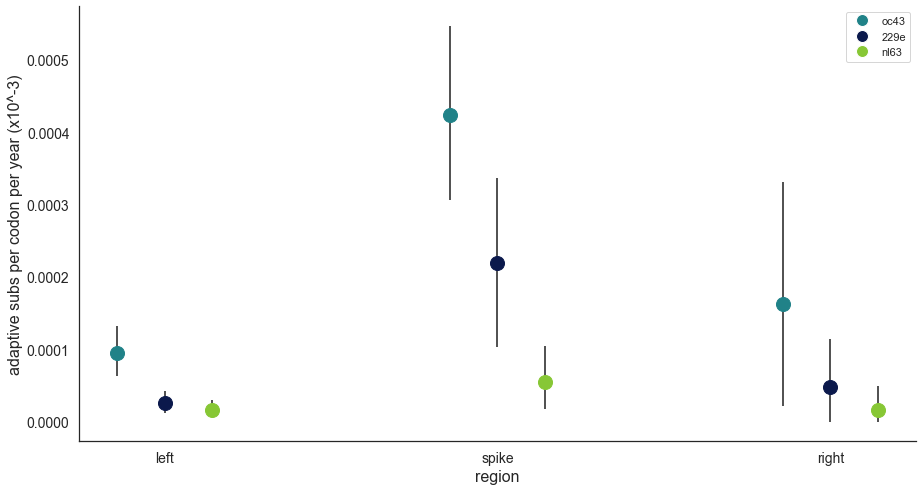

In [74]:
average_rates(['oc43', '229e', 'nl63'], True, filename='rates_leftandright_of_spike.png')